## [1. Question Posed](#Question)

## [2. Handling the missing/NA values](#NA)

## [3. Exploring Data and Visualization](#Exploring)

[3.1 Age, Sex, Pclass and Survival Rate](#Age, Sex, Pclass)

[3.2 Other Factors and Survival Rate](#Others)

[3.3 What patterns can be found in the ticket class?](#Pclass)

## [4. Drawing Conclusions](#Conclusions)

---
<a id="Question"></a>
## 1. Question Posed

As we all konw, Titanic event is one of the most famous disasters throughout the world. More than 1500 people total died, including passengers and crew, and there were an estimated 2224 people aboard the ship.  I'm curious about the survival rate patterns over age, sex and social-economic statu, e.g. 
- During all the rescues, was the priority given to the children? What about the females?
- Were people with low social-economic status treated equally during the rescues?

Thus the follwing questions are my concern:

- **What variables are related to survival rate?**

    - What gender has a better survival rate?
    - Among the dead, how old is the oldest person？ And the youngest?
    - What are the survival rate patterns over age?
    - Are those passengers having higher ticket class likely to survive?
    - How does the interpersonal relationships (*siblings/spouses* and *parents/children*) affect the survival rate?
   
   
- **What patterns can I find on the ticket class?**

    - What's the distribution of ages and genders on each class?
    - What port did they embark from?

DataSet Source: https://www.kaggle.com/c/titanic/data

***
<a id='NA'></a>
## 2. Handling the missing/NA values
Before investigating the survived rata pattern over age, we need to check the **missing/NA values** related to 'Age' and fix them.

In [104]:
# First of all, We need to load datas from the csv file.
# Import required modules
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

# load the csv file
data = pd.read_csv('titanic-data.csv')
data.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [105]:
# Identify the fields containing missing/NA values and the amount
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [106]:
data_by_PclassSex = data.groupby(['Pclass', 'Sex']).mean()['Age']
data_by_PclassSex

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [107]:
# Create a empty DataFrame to contenate multiple fixed DataFrame
fixed_age = pd.DataFrame(columns=['Age'])

# Replace the NA values of Age with the mean age by categories
for pclass, sex in data_by_PclassSex.index:
    filtered_age = data[(data['Pclass']==pclass) & (data['Sex']==sex)]['Age']
    filtered_age = filtered_age.fillna(data_by_PclassSex.loc[pclass, sex])
    fixed_age = pd.concat([fixed_age, filtered_age]).astype('float64')

# Assign the fixed column to the origin 
# and see the first five rows of the dataset
data['Age'] = fixed_age
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---
<a id="Exploring"></a>
## 3. Exploring Data and Visualization
<a id="Age, Sex, Pclass"></a>
#### 3.1 Age, Sex, Pclass and Survival Rate

In [108]:
# Set the fixed bins
bin_values = np.arange(start=0, stop=90, step=10)
bin_values

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80])

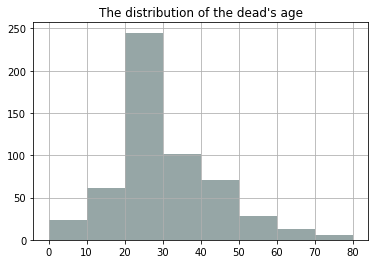

In [354]:
# Select the data of the dead
dead = data[data['Survived']==0]

# Plot the distribution of the dead's age by given bins
dead['Age'].hist(color='darkslategray', alpha=0.5, bins=bin_values)
plt.title('The distribution of the dead\'s age')
plt.show()

The dead are mainly young people, especially those aged 20-30. The vast majority of the dead are less than 50 years old.

In [110]:
# Get the descriptive statistics for the age of the dead
dead['Age'].describe()

count    549.000000
mean      30.025651
std       12.769635
min        1.000000
25%       22.000000
50%       26.507589
75%       37.000000
max       74.000000
Name: Age, dtype: float64

The average age of the dead is about 30, and 75% of them aren't more than 37 years old. The oldest deceased is as much as 74 years old, and the youngest is only 1 years old. We may go through their profiles by the follwing way.

In [111]:
# Get the profile of the youngest deceased
dead.loc[dead['Age'].argmin()]

PassengerId                             165
Survived                                  0
Pclass                                    3
Name           Panula, Master. Eino Viljami
Sex                                    male
Age                                       1
SibSp                                     4
Parch                                     1
Ticket                              3101295
Fare                                39.6875
Cabin                                   NaN
Embarked                                  S
Name: 164, dtype: object

We can see the youngest deceased is a baby boy with the lowest ticket class.

In [112]:
# Get the profile of the oldest deceased
dead.loc[dead['Age'].argmax()]

PassengerId                    852
Survived                         0
Pclass                           3
Name           Svensson, Mr. Johan
Sex                           male
Age                             74
SibSp                            0
Parch                            0
Ticket                      347060
Fare                         7.775
Cabin                          NaN
Embarked                         S
Name: 851, dtype: object

The oldest deceased is a old man and he also has the lowest class of ticket.

In [113]:
# Calculate the count of the dead and survivors
count_survivors = data['Survived'].value_counts()
count_survivors

0    549
1    342
Name: Survived, dtype: int64

In [114]:
# Get the overall survival rate and round the number
overall_survivalRate = count_survivors[1] / count_survivors.sum().astype(float)
overall_survivalRate = round(overall_survivalRate, 3)
print("The overall survival rate of the disaster is %s." % overall_survivalRate)

The overall survival rate of the disaster is 0.384.


In [115]:
# Define a function to group the data to see the distribution of survivors
# and get the survival rate of each group
def group_survivalDistr(dataframe_name, field_name):
    grouped_survived = dataframe_name.groupby([field_name, 'Survived']).size().unstack()
    grouped_survived.fillna(0, inplace=True)
    grouped_survived['ratio_survived'] = (grouped_survived[1] / 
                                             (grouped_survived[0] + 
                                              grouped_survived[1])).round(3)
    return grouped_survived

In [116]:
# Cut the age by the given bins and add ageBinned column
data['ageBinned'] = pd.cut(data['Age'], bins=bin_values)

# Apply the survival distribution function for ageBinned
survivalRate_by_ageBinned = group_survivalDistr(data, 'ageBinned')
survivalRate_by_ageBinned

Survived,0,1,ratio_survived
ageBinned,,,
"(0, 10]",26,38,0.594
"(10, 20]",71,44,0.383
"(20, 30]",248,120,0.326
"(30, 40]",93,80,0.462
"(40, 50]",69,38,0.355
"(50, 60]",25,17,0.405
"(60, 70]",13,4,0.235
"(70, 80]",4,1,0.200


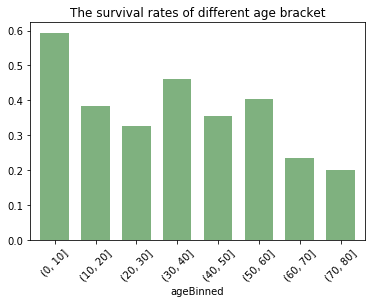

In [355]:
# Plot the survival rate of each group
survivalRate_by_ageBinned['ratio_survived'].plot.bar(color='darkgreen', rot=45, alpha=0.5, width=0.7)
plt.title('The survival rates of different age bracket')
plt.show()

The first bar of the two charts above shows the suvival rate of **infant children** is nearly 0.6, higher than other groups and the overall survival rate(0.384).

I also want to konw what **gender** has a better survival rate. Does the conclusion apply equally to the children?

In [118]:
# Get the survival distributions of differrent genders and specify the dataset name
overall_sex_survivalDistr = group_survivalDistr(data, 'Sex')
overall_sex_survivalDistr.name = 'overall_sex_survivalDistr'

# Select the sub-dataset of the children with the highest survival rate
children = data[data['Age'] <= 10]

# Get the survival distributions of boys and girls and specify the dataset name
children_sex_survivalDistr = group_survivalDistr(children, 'Sex')
children_sex_survivalDistr.name = 'children_sex_survivalDistr'

In [119]:
# Create a function to compare the survival rates of two datasets 
# grouped by the same two fileds, such as sex and survival rate
# and visualize the result

def compare_survivalDistr(dataset1, dataset1_name, dataset2, dataset2_name, title):
    N = len(dataset1['ratio_survived'])
    ind = np.arange(N)
    width = 0.25
    graph_width = max(ind) * 3 + 3
    
    fig, ax = plt.subplots(figsize=[graph_width, 6])
    
    rects1 = plt.bar(ind, 
                     dataset1['ratio_survived'], 
                     width,
                     alpha=0.5, 
                     label=dataset1.index[0])

    rects2 = plt.bar([i + width for i in ind], 
                     dataset2['ratio_survived'], 
                     width,
                     alpha=0.5, 
                     label=dataset1.index[1])
    
    ax.set_ylabel('survivalRate')
    ax.set_xticks([i + width / 2 for i in ind])
    ax.set_xticklabels(dataset1.index)
    
    def autolabel(rects):
        """
        Create a function to attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 0.01, float(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    plt.xlim(-width, max(ind) + width * 2)
    plt.ylim(0, 1.1)
    plt.title(title, fontsize=12)
    plt.legend([dataset1_name, dataset2_name], loc='upper right')
            
    plt.grid()
    plt.show()

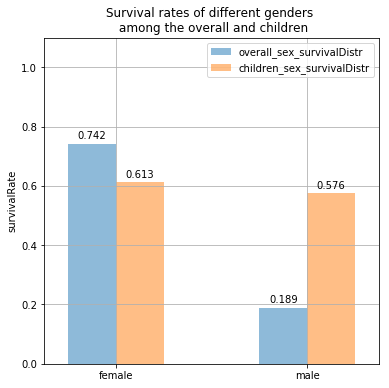

In [120]:
title = 'Survival rates of different genders \n among the overall and children' # title of plot
compare_survivalDistr(overall_sex_survivalDistr, overall_sex_survivalDistr.name,
                      children_sex_survivalDistr, children_sex_survivalDistr.name,
                      title) # compare the survival rates

- As shown in the blue bar graphs, the overall survival rate of females (0.742) is more than 4 times that of males(0.189). It seems that **women** have acquired enough care in rescues.

- However, the preferential treatment for females doesn't aplly to children, whose data is displayed in yellow. Among the children, the survival rates of boys(0.576) and girls(0.613) are **almost the same**. Interestingly, the girls' survival rate(0.613) is lower than the overall survival rate of females(0.742).

Still a small number of women are excluded from the list of survivors. So what is the common characteristic of those **servived women**? Does the characteristic include the **ticket class**, which represents the social-economic status?

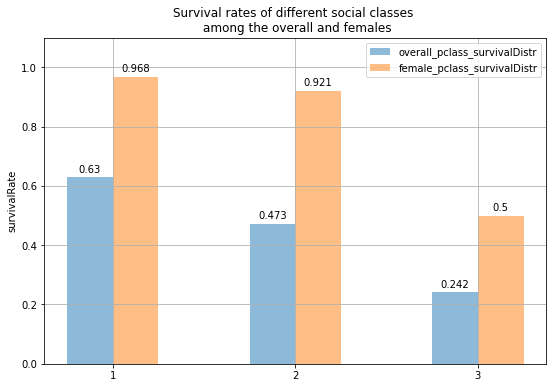

In [121]:
# Get the survival distributions of differrent social-economic status and specify the dataset name
overall_pclass_survivalDistr = group_survivalDistr(data, 'Pclass')
overall_pclass_survivalDistr.name = 'overall_pclass_survivalDistr'

# Select the sub-dataset of females
females = data[data['Sex']=='female']

# Get the survival distributions of boys and girls and specify the dataset name
female_pclass_survivalDistr = group_survivalDistr(females, 'Pclass')
female_pclass_survivalDistr.name = 'female_pclass_survivalDistr'

# Set the title of the plot
title = 'Survival rates of different social classes \n among the overall and females'

# Compare the survival rates of all passengers and females in each social class
compare_survivalDistr(overall_pclass_survivalDistr, overall_pclass_survivalDistr.name,
                      female_pclass_survivalDistr, female_pclass_survivalDistr.name,
                      title)

- As shown the blue bar graphs, the survival rate of the passengers with ticket class 2 is almost twice that of those people with ticket class 3. That means **the higher social-economic class a passenger belongs, the more likely it is for he/she to be saved from the disaster**, which we call it **_law of ticket class and survival rate_** for the time being. Next, we'll realize the **universality** of the law. 

- The orange bar graphs reveal that the survival rate of females is always higher than the overall rate on each social class, which illustrates a situation that **females have received priority** in rescues.

- Although females have got proper care in rescues, the degrees of care for **females of different social classes** are not the same. The survival rate of females with first two ticket classes are more than 0.9, while **only half** of females with the lowest ticket class can be rescued, which just coincides with the law above.

What about the care for **children with different ticket classes**?

In [122]:
# Get the survival distributions of children of differrent social classes
group_survivalDistr(children, 'Pclass')

Survived,0,1,ratio_survived
Pclass,,,
1,1.0,2.0,0.667
2,0.0,17.0,1.000
3,25.0,19.0,0.432


The number of childrewn with ticket class 1 is too small to be considered. All of the children with ticket class 2 are saved, while the survival rate of children with ticket class 3 is only less than half. That is to say, the **_law of ticket class and survival rate_** can apply to women and children.

<a id="Others"></a>
#### 3.2 Other Factors and Survival Rate

In [123]:
# Get the survival distributions of differrent # of siblings / spouses
SibSp_survivalDistr = group_survivalDistr(data, 'SibSp')
SibSp_survivalDistr.name = 'SibSp_survivalDistr'

# Get the survival distributions of differrent # of parents / children
Parch_survivalDistr = group_survivalDistr(data, 'Parch')
Parch_survivalDistr.name = 'Parch_survivalDistr'

title = 'Survival rates of passengers with different number \n of siblings / spouses and parents / children'

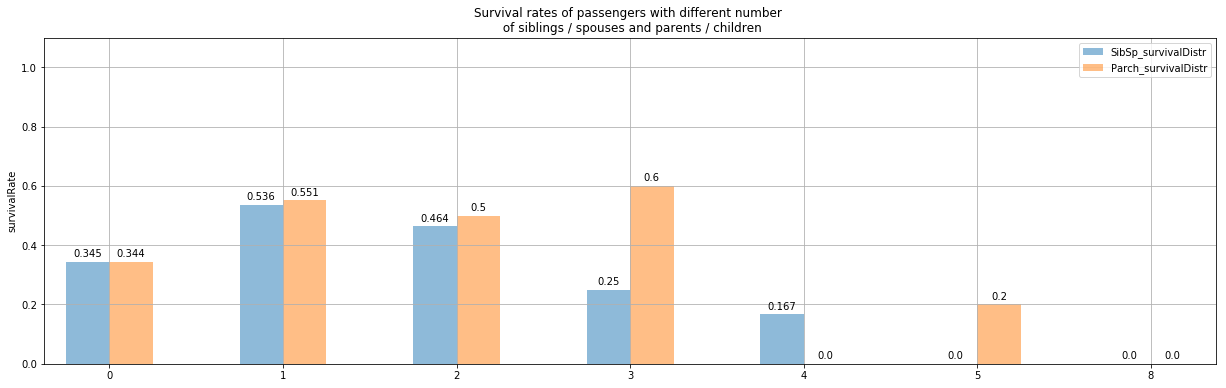

In [124]:
# Compare the survival rates of siblings / spouses and parents / children
compare_survivalDistr(SibSp_survivalDistr, SibSp_survivalDistr.name, 
                      Parch_survivalDistr, Parch_survivalDistr.name,
                      title)

As shown in the figure, those passengers with **more than 3 family members** have a lower chance of survival, less than the overall survival rate(0.384). I thought people in a big family may support each other better, so what's the reason for the lower survival chance. Is this related to their social classes or genders?

In [192]:
# Select the sub-dataset of passengers with more than 3 family members
familyRelat = data[(data['SibSp']>3) | (data['Parch']>3)]

grouped_familyRelat = familyRelat.groupby(['Sex', 'Pclass']).size().unstack()
grouped_familyRelat

Pclass,1,3
Sex,,
female,NaN,17.0
male,1.0,22.0


We can see almost all the passengers with more than 3 family members are **at the bottom of the socity**. That may be the reason for low survival chance.

In [130]:
# Get the survival distributions of differrent social classes of them
group_survivalDistr(familyRelat, 'Pclass')

Survived,0,1,ratio_survived
Pclass,,,
1,1.0,0.0,0.000
3,35.0,4.0,0.103


These people with ticket class 3 have a proporlity of 0.103 to survive, obviously less than the overall 0.384.

<a id="Pclass"></a>
#### 3.3 What patterns can I find in the ticket class? 

In [326]:
# Compute the descriptive statistics of age on each social class
age_statistics = data.groupby(['Pclass'])['Age'].describe()
age_statistics

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,38.378866,13.783477,0.92,29.00,38.0,47.25,80.0
2,184.0,29.907295,13.575612,0.67,23.00,30.0,36.00,70.0
3,491.0,25.112288,10.683755,0.42,20.25,26.0,29.00,74.0


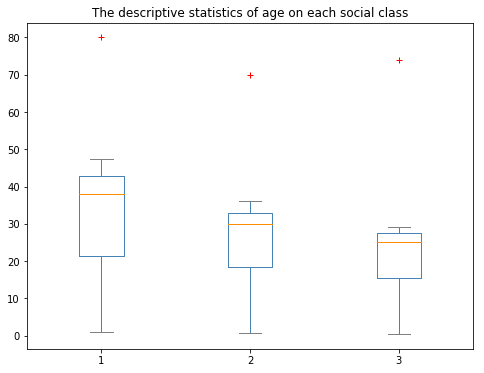

In [327]:
# Leave out the count column and do the transposition
age_statistics = age_statistics.drop('count', axis=1).T

# Visualize the statistics by creating boxplots
color = dict(boxes='SteelBlue', whiskers='SteelBlue',
             medians='DarkOrange', caps='Gray')
age_statistics.plot.box(figsize=[8, 6], color=color, sym='r+')
plt.title('The descriptive statistics of age on each social class')
plt.show()

- **The higher the social class, the greater the average age**. The averege age of passengers with lowest social class is 25.1 years old, wihle that of passengers with highest social class is 38.4.
- **The higher the social class, the larger dispersion of age the class has**. The highest class has the maximum standard deviation of age.

In [333]:
# Get the composition of each social class by creating a function
def get_composition(field_name, fig_titile):
    count_grouped = data.groupby(['Pclass', field_name]).size().unstack()

    count_grouped = count_grouped.apply(lambda x: x/x.sum(), axis=1)
    count_grouped = count_grouped.add_prefix('ratio_')

    count_grouped.plot.bar(stacked=True, alpha=0.5, rot=0)

    plt.title(fig_titile)
    plt.ylim(0, 1)

    plt.show()

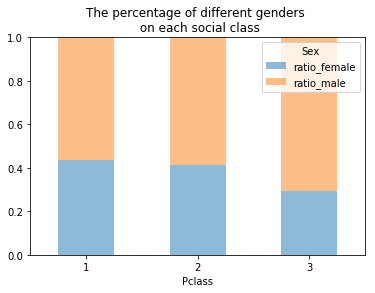

In [340]:
title = 'The percentage of different genders \n on each social class'
get_composition('Sex', title)

Althought the three groups of passengers are mainly male, the third class account for the highest proportion of male.

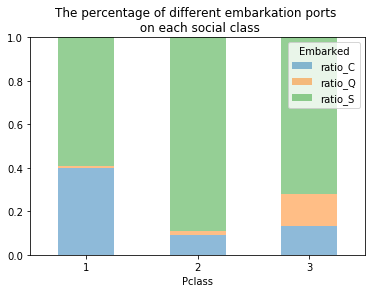

In [343]:
title = 'The percentage of different embarkation ports \n on each social class'
get_composition('Embarked', title)

Despite of the majority of passengers on each class embarking from Southampton(S) port, most people with ticket class 1 come from Cherbourg(C), and people with ticket class 3 are mainly from Queenstown(S) port. That reprents there are more rich in Cherbourg than in Queenstown.

<a id="Conclutions"></a>
## 4. Drawing Conclusions